In [136]:
%matplotlib inline
from sklearn.datasets import load_iris, load_breast_cancer,load_wine
import matplotlib.pyplot as plt
import numpy as np

In [137]:
import seaborn as sn;
import pandas as pd;

In [138]:
#dataset = load_iris()
#dataset = load_breast_cancer();
dataset = load_wine()

In [149]:
def analysisPlot(x,y, title='',xlabel='x'):
    y = np.array(y, dtype=np.float32)
    index = np.argsort(x);
    cny=(1-y)[index].cumsum()/(1-y).sum();
    cy = y[index].cumsum()/y.sum();
    ks = np.abs(cny-cy).max();
    plt.title(title +" KS %0.2f" % ks)
    plt.hist(x[y==False],alpha=0.7,color='red', bins=10)
    plt.hist(x[y==True],alpha=0.7,color='blue')
    plt.xlabel(xlabel)
    ax2 = plt.twinx()
    ax2.plot(x[index],cny,color='red')
    ax2.plot(x[index],cy,color='blue')   
    ax2.set_ylabel('Frequency', color='g')
    ax2.set_ylabel('cummulated curve', color='b')
    ax2.set_ylim((0,1.1))


In [140]:
dataset['target_names']

array(['class_0', 'class_1', 'class_2'], dtype='|S7')

In [142]:
from scipy import stats;

corr = [];
for i in range(dataset['data'].shape[1]):
    corr.append(stats.pearsonr(dataset['data'][:,i],dataset['target'])[0])
    
df = pd.DataFrame({
    'feature_names':dataset['feature_names'],
    'arrayKey':range(len(dataset['feature_names'])),
    'personr':corr,
    'personr_abs':np.abs(corr)
}).sort_values('personr_abs',ascending=False).head(10)
df


,arrayKey,feature_names,personr,personr_abs
6,6,flavanoids,-0.847498,0.847498
11,11,od280/od315_of_diluted_wines,-0.788230,0.788230
5,5,total_phenols,-0.719163,0.719163
12,12,proline,-0.633717,0.633717
10,10,hue,-0.617369,0.617369
3,3,alcalinity_of_ash,0.517859,0.517859
8,8,proanthocyanins,-0.499130,0.499130
7,7,nonflavanoid_phenols,0.489109,0.489109
1,1,malic_acid,0.437776,0.437776
0,0,alcohol,-0.328222,0.328222


In [143]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

In [144]:
rfe =RFE(estimator=SVC(kernel="linear", C=1),n_features_to_select=5)
rfe.fit(dataset['data'],dataset['target']==1);

In [145]:
dataset['data'] = dataset['data'][:,rfe.support_]
dataset['feature_names'] = np.array(dataset['feature_names'])[rfe.support_]

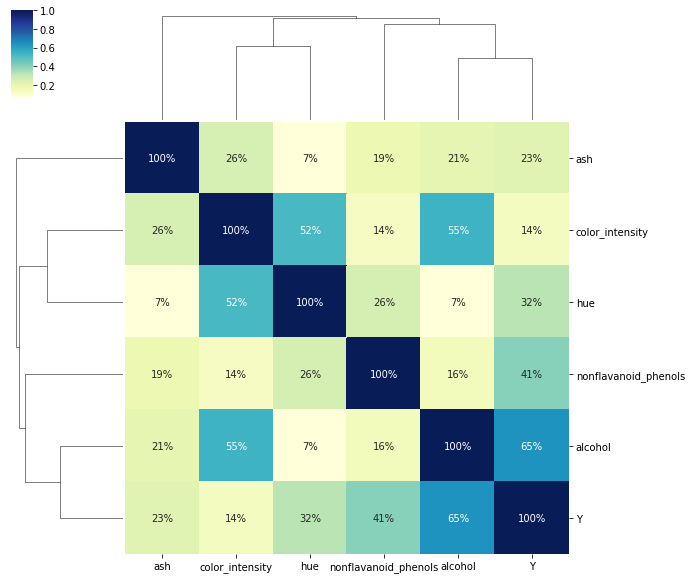

In [146]:
df = pd.DataFrame(dataset['data'], columns=dataset['feature_names']);
df['Y'] = dataset['target']==0;
df = df.corr().abs();
sn.clustermap(df,annot=True, cmap="YlGnBu",
            xticklabels=df.columns.values,
            yticklabels=df.columns.values,
              fmt="0.0%", figsize=(10,10));

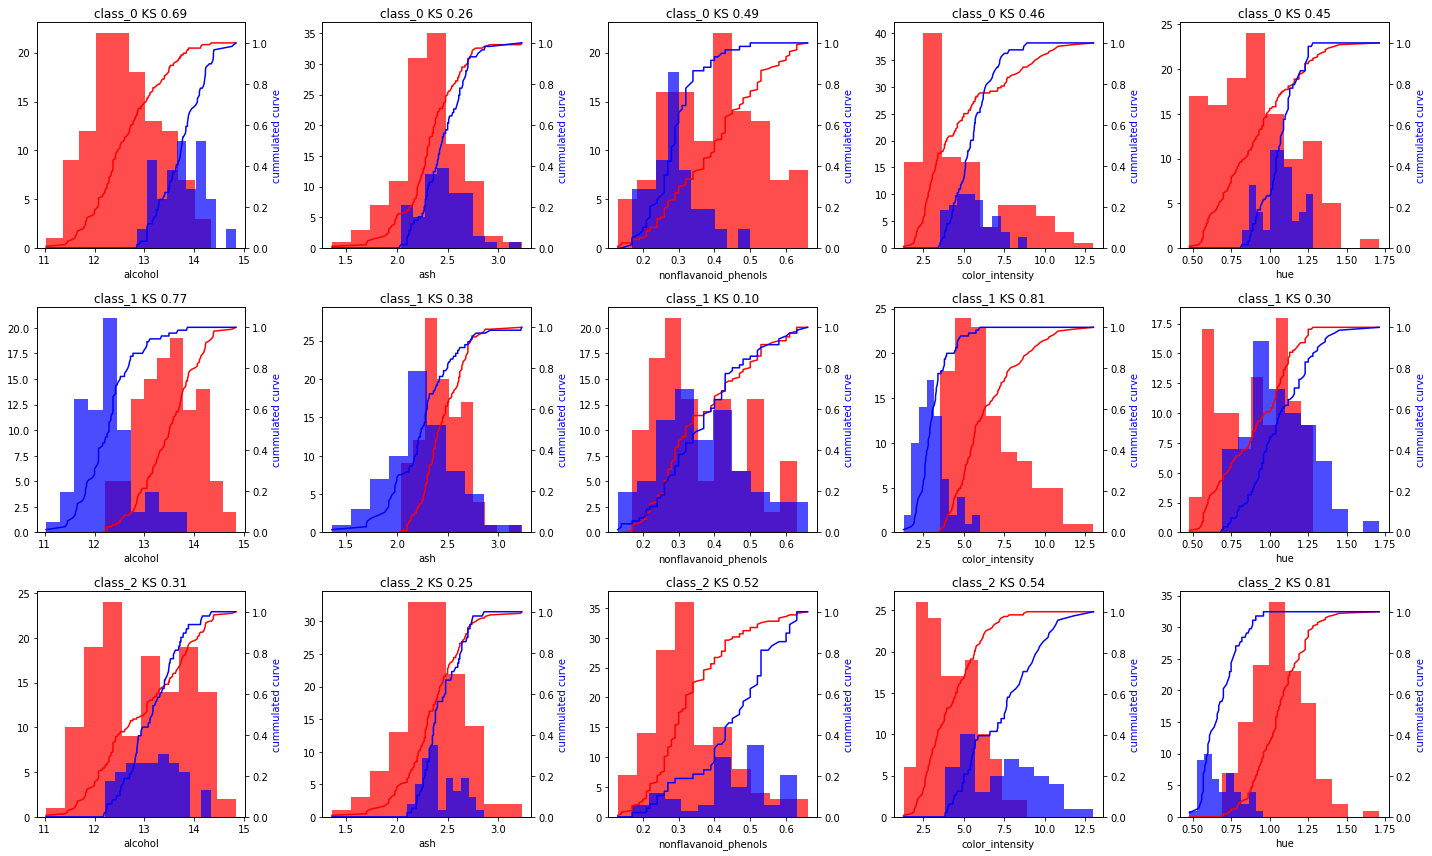

In [150]:
row = len(dataset['target_names'])
col = len(dataset['feature_names'])
plt.figure(figsize=(4*col,4*row))
counter = 1;

for i, target_name in enumerate(dataset['target_names']):
    for j, feature_names in enumerate(dataset['feature_names']):
        plt.subplot(row,col, counter);
        counter +=1;
        analysisPlot(dataset['data'][:,j],dataset['target'] == i, title=target_name, xlabel=feature_names)

plt.tight_layout()

# outlier analysis

In [151]:
from sklearn.metrics import pairwise_distances, pairwise_distances_argmin_min
from sklearn.preprocessing import robust_scale, minmax_scale

In [162]:
dist = pairwise_distances(robust_scale(dataset['data'],quantile_range=(2.5,97.5)),metric='l2')
#dist = pairwise_distances(minmax_scale(dataset['data'], axis=0),metric='minkowski',p=100)

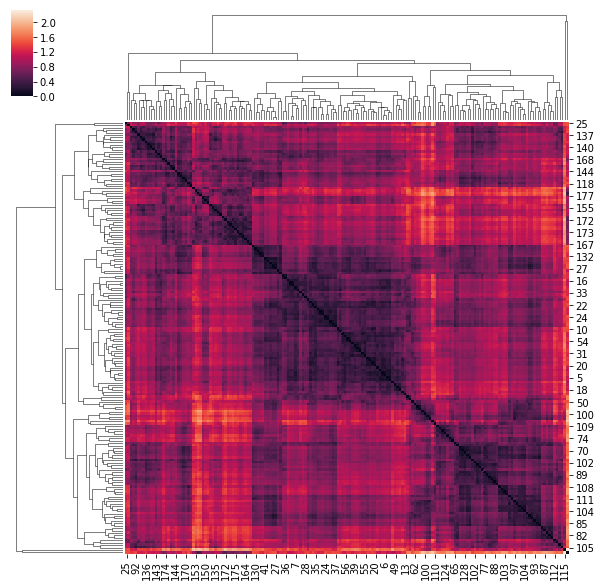

In [163]:
sn.clustermap(dist,metric='euclidean')

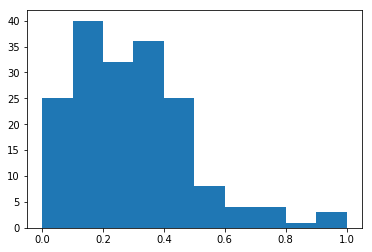

In [164]:
np.set_printoptions(precision=2)
loc = np.mean(np.sort(dist,axis=1)[:,1:50],axis=1)
loc = np.clip(loc,a_min=np.percentile(loc,1), a_max=np.percentile(loc,99))
loc = (loc - loc.min())/(loc.max()-loc.min())
plt.hist(loc);

In [160]:
def contourValues(x,y,pred,h=15):
    x_min, x_max = x.min(), x.max();
    y_min, y_max = y.min(), y.max();
    x_r = x_max-x_min;
    y_r = y_max-y_min;
    x_min -= x_r*0.05;
    x_max += x_r*0.05;
    
    y_min -= y_r*0.05;
    y_max += y_r*0.05;
    
    X = np.linspace(x_min, x_max, h);
    Y = np.linspace(y_min, y_max, h);
    X, Y = np.meshgrid(X, Y);
    z  = pairwise_distances_argmin_min(np.c_[X.ravel(), Y.ravel()], np.c_[x,y],axis=1)[0]
    return X,Y, pred[z.reshape((h,h))]

In [232]:
np.unique(dataset['target'])

array([0, 1, 2])

5


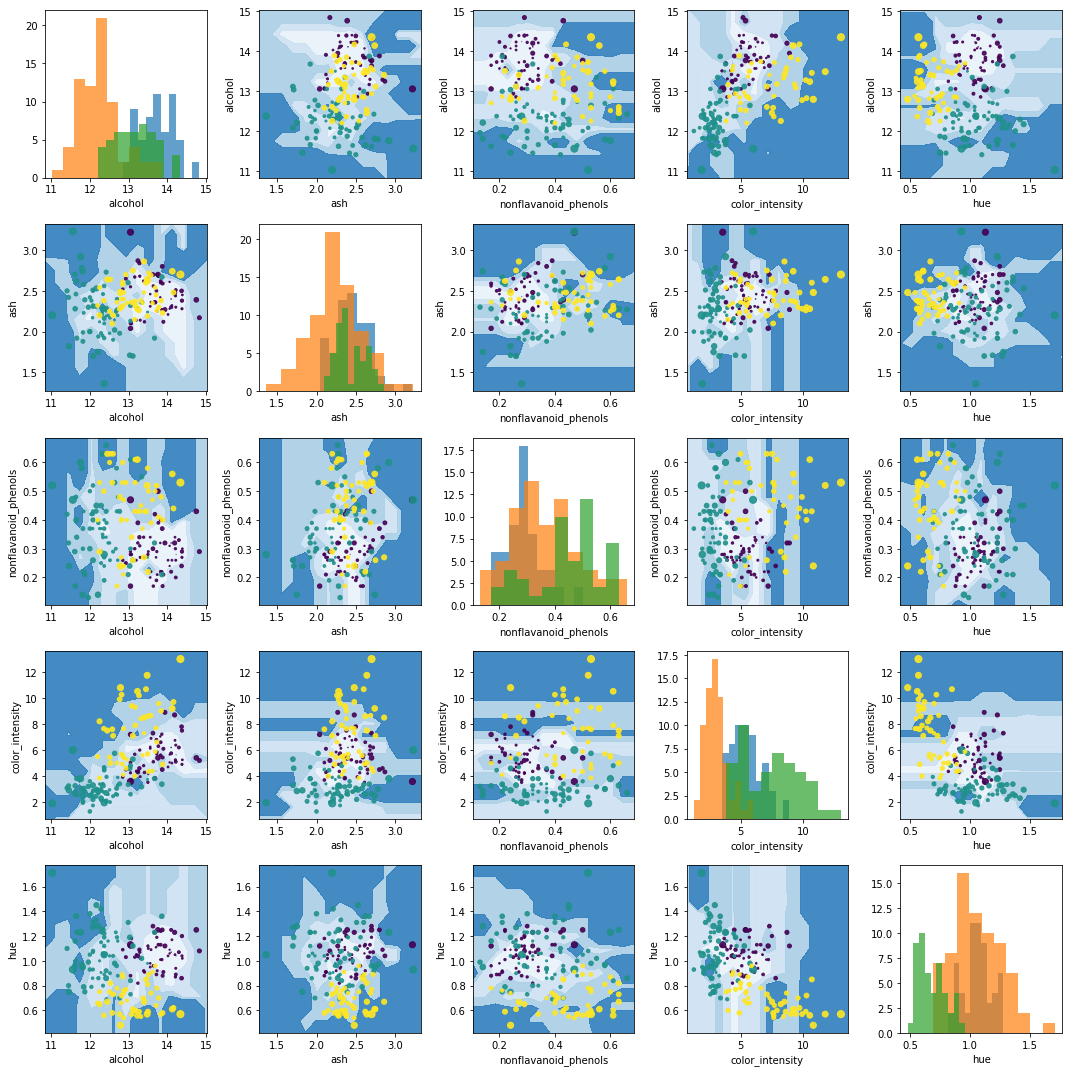

In [239]:
r = len(dataset['feature_names'])
print(r)
fig, axes = plt.subplots(figsize=(15,15), sharex=False, sharey=False, ncols=r, nrows=r)
for i in range(r):
    for j in range(r):
        #print(i,j)
        ax = axes[j,i];
        #ax.set_title("%0.f %0.f" % (i,j))
        
        x=dataset['data'][:,i];
        y=dataset['data'][:,j];
        
        if j == i:
            for t in np.unique(dataset['target']):
                ax.hist(x[dataset['target'] == t], label=dataset['target_names'][t], alpha=0.7)
            ax.set_xlabel(dataset['feature_names'][i]);
            continue
        
        threshold = stats.scoreatpercentile(loc*1.1, np.linspace(0,100,5))
        xx, yy, z = contourValues(x,y, loc);
        
        ax.contourf(xx, yy, z,threshold,  cmap=plt.cm.Blues, alpha=0.9)
        ax.scatter(x, y, s=50*loc, c=dataset['target'],  cmap=plt.cm.viridis, alpha=0.9)
        ax.set_xlabel(dataset['feature_names'][i]);
        ax.set_ylabel(dataset['feature_names'][j]);
        
plt.tight_layout()

In [1]:
def plotKSROC(y_pred, y_true):
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1);
    ks =histKS(y_pred, y_true);
    plt.title("Kolmogorov-Simirnov %0.2f | %0.2f | %0.2f" % (ks[0], ks[1], ks[2]))
    plt.subplot(1,2,2);
    fpr, tpr, thresholds = roc_curve(y_score=y_pred,y_true=y_true)
    plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % auc(fpr,tpr));
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [13]:
import numpy as np

In [82]:
notes = [
    ('C0',16.351598),
('C_S_0',17.323914),
('D0',18.354048),
('D_S_0',19.445436),
('E0',20.601722),
('F0',21.826764),
('F_S_0',23.124651),
('G0',24.499715),
('G_S_0',25.956544),
('A0',27.500000),
('A_S_0',29.135235),
('B0',30.867706),
('C1',32.703196),
('C_S_1',34.647829),
('D1',36.708096),
('D_S_1',38.890873),
('E1',41.203445),
('F1',43.653529),
('F_S_1',46.249303),
('G1',48.999429),
('G_S_1',51.913087),
('A1',55.000000),
('A_S_1',58.270470),
('B1',61.735413),
('C2',65.406391),
('C_S_2',69.295658),
('D2',73.416192),
('D_S_2',77.781746),
('E2',82.406889),
('F2',87.307058),
('F_S_2',92.498606),
('G2',97.998859),
('G_S_2',103.826174),
('A2',110.000000),
('A_S_2',116.540940),
('B2',123.470825),
('C3',130.812783),
('C_S_3',138.591315),
('D3',146.832384),
('D_S_3',155.563492),
('E3',164.813778),
('F3',174.614116),
('F_S_3',184.997211),
('G3',195.997718),
('G_S_3',207.652349),
('A3',220.000000),
('A_S_3',233.081881),
('B3',246.941651),
('C4',261.625565),
('C_S_4',277.182631),
('D4',293.664768),
('D_S_4',311.126984),
('E4',329.627557),
('F4',349.228231),
('F_S_4',369.994423),
('G4',391.995436),
('G_S_4',415.304698),
('A4',440.000000),
('A_S_4',466.163762),
('B4',493.883301),
('C5',523.251131),
('C_S_5',554.365262),
('D5',587.329536),
('D_S_5',622.253967),
('E5',659.255114),
('F5',698.456463),
('F_S_5',739.988845),
('G5',783.990872),
('G_S_5',830.609395),
('A5',880.000000),
('A_S_5',932.327523),
('B5',987.766603),
('C6',1046.502261),
('C_S_6',1108.730524),
('D6',1174.659072),
('D_S_6',1244.507935),
('E6',1318.510228),
('F6',1396.912926),
('F_S_6',1479.977691),
('G6',1567.981744),
('G_S_6',1661.218790),
('A6',1760.000000),
('A_S_6',1864.655046),
('B6',1975.533205),
('C7',2093.004522),
('C_S_7',2217.461048),
('D7',2349.318143),
('D_S_7',2489.015870),
('E7',2637.020455),
('F7',2793.825851),
('F_S_7',2959.955382),
('G7',3135.963488),
('G_S_7',3322.437581),
('A7',3520.000000),
('A_S_7',3729.310092),
('B7',3951.066410),
('C8',4186.009045),
('C_S_8',4434.922096),
('D8',4698.636287),
('D_S_8',4978.031740),
('E8',5274.040911),
('F8',5587.651703),
('F_S_8',5919.910763),
('G8',6271.926976),
('G_S_8',6644.875161),
('A8',7040.000000),
('A_S_8',7458.620184),
('B8',7902.132820),
]

In [87]:
import sounddevice as sd
import random
import numpy as np
import time
from __future__ import print_function

duration=0.5
amp=1E4
rate=44100

def note(freq, duration, amp, rate):
    t = np.linspace(0, duration, duration * rate)
    data = np.sin(2*np.pi*freq*t)*amp
    return data.astype(np.float) # two byte integers


tone0 = note(0, duration, amp, rate) #silence
tone1 = note(261.63, duration, amp, rate) # C4
tone2 = note(329.63, duration, amp, rate) # E4
tone3 = note(392.00, duration, amp, rate) # G4
tone4 = note(440.00, duration, amp, rate) # G4

/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':


In [78]:
sd.play(tone4, 44100)

In [80]:
sd.play(note(notes['A4'], duration, amp, rate), 44100)

/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()


In [157]:
for name, f in notes:
    print(name, end=" ")
    sd.play(note(f, duration, amp, rate), 44100)
    time.sleep(0.2)

C0 

/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':


C_S_0 D0 D_S_0 E0 F0 F_S_0 G0 G_S_0 A0 A_S_0 B0 C1 C_S_1 D1 D_S_1 E1 F1 F_S_1 G1 G_S_1 A1 A_S_1 B1 C2 C_S_2 D2 D_S_2 E2 F2 F_S_2 G2 G_S_2 A2 A_S_2 B2 C3 C_S_3 D3 D_S_3 E3 F3 F_S_3 G3 G_S_3 A3 A_S_3 B3 C4 C_S_4 D4 D_S_4 E4 F4 F_S_4 G4 G_S_4 A4 A_S_4 B4 C5 C_S_5 D5 D_S_5 E5 F5 F_S_5 G5 G_S_5 A5 A_S_5 B5 C6 C_S_6 D6 D_S_6 E6 F6 F_S_6 G6 G_S_6 A6 A_S_6 B6 C7 C_S_7 D7 D_S_7 E7 F7 F_S_7 G7 G_S_7 A7 A_S_7 B7 C8 C_S_8 D8 D_S_8 E8 F8 F_S_8 G8 G_S_8 A8 A_S_8 B8 

In [89]:
def recaman(n):
    seq = [0];
    seqCurrent =1;
    for i in range(1,n):
        seqCurrent = seq[-1] - i;
        if seqCurrent <0 or seqCurrent in seq:
            seqCurrent = seq[-1] + i;
        seq.append(seqCurrent)
    return seq;

In [91]:
notes[0]

('C0', 16.351598)

In [117]:
len(notes)

108

In [163]:
duration=0.2
amp=1E4
rate=44100

dicNotes = dict(notes);

for n in 'C C D C F E C C D C G F C C C A F F E D B B A F G F'.split(' '):
        sd.play(note(dicNotes[n+"2"], duration, amp, rate), 44100)
        time.sleep(duration)    

/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':


In [175]:
duration=0.2
amp=1E6
rate=44100

for i in recaman(30):
    j = (i) % len(notes);
    i = (i+30) % len(notes);
    print(i, notes[i][0])
    n = note(notes[i][1], duration, amp, rate);
    n += note(notes[j][1], duration, amp, rate);
    
    sd.play(n, 44100)
    time.sleep(duration)


30 F_S_2


/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':


31 G2
33 A2
36 C3
32 G_S_2
37 C_S_3
43 G3
50 D4
42 F_S_3
51 D_S_4
41 F3
52 E4
40 E3
53 F4
39 D_S_3
54 F_S_4
38 D3
55 G4
73 C_S_6
92 G_S_7
72 C6
93 A7
71 B5
48 C4
72 C6
47 B3
73 C_S_6
46 A_S_3
74 D6
45 A3
